# Minimos cuadrados no lineales

Supongamos que disponemos de un conjunto de datos $\{(x_i,y_i)\}_{i=1,\ldots,m}$. En general, los datos $y_i$ son la respuesta de un sistema a ciertas entradas dadas por las variables $x_i$. El objetivo es hallar una función $f$ tal que $y_i \approx f(x_i)$. A $f$ se le conoce como *función de regresión*.

En general, no queremos $y_i=f(x_i)$ exactamente, ya que las medidas $y_i$ pueden tener error. Lo que se busca es que la función $f$ sea sencilla, por ejemplo pertenezca a una familia paramétrica.



## Criterio de mínimos cuadrados

Para un conjunto de datos dado, existen muchas posibles $f$ que aproximan. El criterio de mínimos cuadrados establece una forma de elegir la función de regresión que mejor ajusta.

El criterio es el siguiente:

> **Criterio de mínimos cuadrados:** Dado un conjunto de datos $\{(x_i,y_i)\}_{i=1,\ldots,m}$ y una función de regresión $f(x;\theta)$ dependiente de uno o más parámetros, elegimos $\theta$ de manera que se alcance:
>
> $$\min_{\theta} \sum_{i=1}^m (y_i - f(x_i;\theta))^2.$$

El vector de parámetros $\hat{\theta}$ que alcanza el mínimo nos da la función de regresión óptima.

## El caso no lineal

El caso no lineal es cuando la función $f(x;\theta)$ no es lineal en los parámetros. En dicho caso, no hay una solución explícita como lo eran las ecuaciones normales.

### Ejemplo

Supongamos que se analiza la respuesta al impulso de un sistema de primer orden. La misma tiene la forma:

$$y = \theta_1 e^{-\theta_2 x}.$$

Si se dispone de una serie de medidas $(x_i,y_i)$, se podría ajustar $\theta_1$ y $\theta_2$ para identificar los parámetros del sistema. Sin embargo, ambos parámetros entran de forma no lineal en la función $f$.

### Alternativas

1. Algunas veces, es posible realizar un cambio de variable que convierta el problema en uno lineal. En ese caso, se aplican las ecuaciones normales y luego se deshace el cambio de variable para hallar $\theta$.

2. Se busca minimizar la función de error $R(\theta)$ directamente usando métodos iterativos. Por ejemplo, veremos el método de *Gauss-Newton*.

## Transformación de variables

En este caso, se busca una transformación de los datos $(x_i,y_i)$ que vuelva la relación entre ellos lineal en los parámetros.

### Ejemplo:

Supongamos que $f(x;\theta)$ es la anterior, es decir la relación es de la forma:

$$y=\theta_1 e^{-\theta_2 x}.$$

Aplicando logaritmos de ambos lados de la ecuación queda:

$$\log(y) = \log(\theta_1) - \theta_2 x = \tilde{\theta_1} + \tilde{\theta_2} x$$

Es decir, los datos $(x,\log(y))$ están relacionados por una recta de parámetros $\tilde{\theta}$. Ajustando a una recta mediante las ecuaciones normales, luego podemos deshacer el cambio y hallar $\theta_1 = e^{\tilde{\theta_1}}$ y $\theta_2 = -\tilde{\theta_2}$.

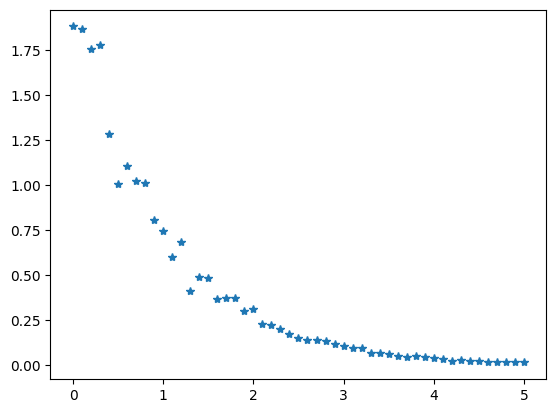

In [1]:
## Ejemplo de minimos cuadrados por transformacion de variables
using Distributions, PyPlot

x=collect(0:.1:5)
theta_real = [2.0;1.0];
yreal = theta_real[1]*exp.(-theta_real[2]*x);

y=yreal.*(1 .+0.1*rand(Normal(),size(yreal)));

plot(x,y,"*");

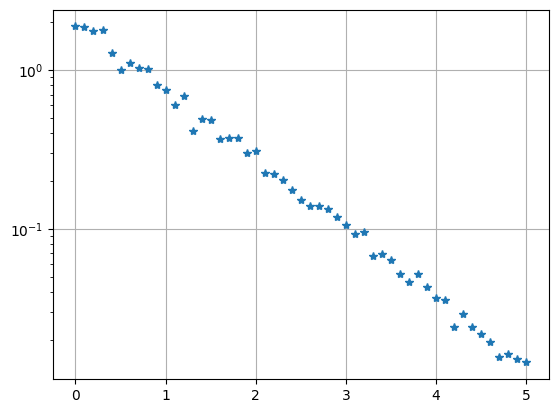

In [2]:
#Grafico en escala semilogaritmica

semilogy(x,y,"*");
grid();

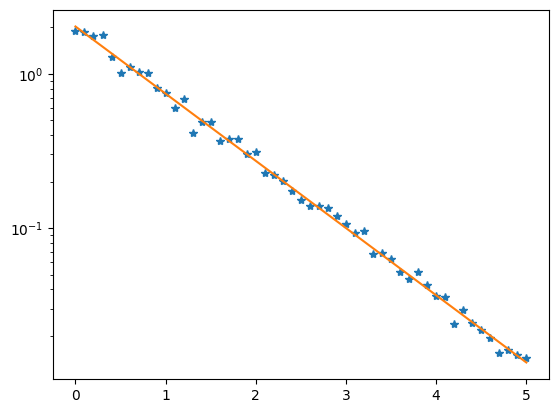

Parámetros de la recta: [0.7026479431685112, -1.001956234989368]


In [3]:
#Ajuste a una recta del cambio de variables

A=[ones(size(x)) x];
b=log.(y);

theta_tilde = (A'*A)\(A'b);

println("Parámetros de la recta: $theta_tilde")

semilogy(x,y,"*");
semilogy(x,exp.(A*theta_tilde));

theta_1=2.019092076248039
theta_2=1.001956234989368


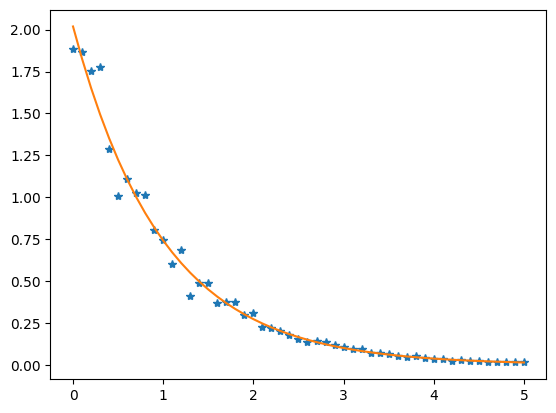

Residuo = 0.21181744879226774


In [4]:
# Recupero los valores de theta deshaciendo el cambio

theta_1 = exp(theta_tilde[1])
theta_2 = -theta_tilde[2];

yest = theta_1*exp.(-theta_2*x);
r=(y-yest);

plot(x,y,"*")
plot(x,yest);
println("theta_1=$theta_1")
println("theta_2=$theta_2")
println("Residuo = $(sum(r.^2))")

## Método de Gauss-Newton

Volvamos ahora al problema original, con una función de regresión $f(x;\theta)$ genérica:

$$\min_{\theta} \sum_{i=1}^m (y_i - f(x_i;\theta))^2.$$

Para $f$ dada, podemos construir la función de $F:\mathbb{R}^n \to \mathbb{R}^m$ tal que a cada conjunto de parámetros $\theta$ le asigna el vector:

$$ \theta \mapsto \left(\begin{array}{c} f(x_1;\theta) \\ \vdots \\ f(x_m;\theta)\end{array}\right) = F((x_1,\ldots,x_m);\theta).$$


El problema puede reescribirse como:

$$\min_{\theta} \| y - F(x;\theta)\|^2.$$

con $y=(y_1,\ldots,y_m)$ dado y $\theta\in \mathbb{R}^n$.


**Idea:** Sustituir $F$ por una aproximación lineal, resolver utilizando dicha aproximación y conseguir un nuevo estimado de solución, iterando esta idea.

### Aproximación de $F(\theta)$.

La función $F:\mathbb{R}^n \to \mathbb{R}^m$ por lo que dado un valor de $\theta=\theta^{(0)}$, su desarrollo de taylor es:

$$F(x;\theta) \approx F(x;\theta^{(0)}) + J_F(x;\theta^{(0)}) (\theta - \theta^{(0)})$$

con $J_F(x;\theta^{(0)})$ la *matriz jacobiana* de $m\times n$ con entradas:

$$J_F(x;\theta^{(0)}) = \left(\begin{array}{ccc} \frac{\partial f(x_1;\theta)}{\partial \theta_1} & \cdots & \frac{\partial f(x_1;\theta)}{\partial \theta_n} \\ \vdots & \ddots & \vdots \\ \frac{\partial f(x_m;\theta)}{\partial \theta_1} & \cdots & \frac{\partial f(x_m;\theta)}{\partial \theta_n} \end{array}\right),$$

donde las derivadas están evaluadas en el punto $\theta=\theta^{(0)}$.

### Aproximación del residuo $R(\theta)$.

Sustituyendo la aproximación lineal en el problema original queda:

$$R(\theta) = \|y-F(x;\theta)\|^2 \approx \|y-F(x;\theta^{(0)}) - J_F(x;\theta^{(0)}) (\theta - \theta^{(0)})\|^2.$$

Llamando $r_0$ al vector $r_0 = y-F(x;\theta^{(0)})$ y $\delta \theta = \theta - \theta^{(0)}$ al vector de paso el problema aproximado queda:

$$\min_\theta \|r_0 -  J_F(x;\theta^{(0)}) \delta \theta\|^2.$$

Este problema es un mínimos cuadrados lineal con término independiente $r_0$ y matriz $J_F(x;\theta^{(0)})$.

Resolviendo el problema anterior, se halla el $\delta \theta$ óptimo y tenemos una aproximación al óptimo $\theta^{(1)} = \theta^{(0)} + \delta \theta$. Luego se itera el procedimiento, calculando un nuevo residuo y jacobiano, hasta la convergencia.

### Algoritmo de Gauss-Newton

1. Se elige una condición inicial de los parámetros $\theta^{(0)}$.
2. En el paso $k$, se calcula $r_k = y-F(x;\theta^{(k)})$ y $J_F(x;\theta^{(k)})$.
3. Se resuelve el problema lineal $\min_\theta \|r_k -  J_F(x;\theta^{(k)}) \delta \theta\|^2$ utilizando ec. normales o QR.
4. Se toma $\theta^{(k+1)} = \theta^{(k)} + \delta \theta$, $k=k+1$ y se vuelve al paso 2.

**Criterios de parada**: se detiene si $\|\delta \theta\| < tol$ (convergencia) o $k>maxiter$ un cierto no. de iteraciones predeterminado.

### Ejemplo

Retomemos el ejemplo del sistema de primer orden, con $f(x;\theta) = \theta_1 e^{-\theta_2 x}$, pero resolvamos ahora por Gauss-Newton.

La función $F(x;\theta)$ es simplemente el vector:

$$F(x;\theta) = \left(\begin{array}{c} \theta_1 e^{-\theta_2 x_1} \\ \vdots \\  \theta_1 e^{-\theta_2 x_m}\end{array}\right).$$

Y las derivadas parciales son:

$$\frac{\partial f(x;\theta)}{\partial \theta_1} = e^{-\theta_2 x} \quad \quad  \frac{\partial f(x;\theta)}{\partial\theta 2} = -\theta_1 x e^{-\theta_2 x}.$$

Por lo tanto, la matriz jacobiana a usar en cada paso queda:

$$J_F(x,\theta) = \left(\begin{array}{cc} e^{-\theta_2 x_1} &  -\theta_1 x_1 e^{-\theta_2 x_1} \\ \vdots  & \vdots \\  e^{-\theta_2 x_m} &  -\theta_1 x_m e^{-\theta_2 x_m} \end{array}\right).$$

Construimos ahora dos funciones que calculan $F$ y $J$ y luego una función genérica para el Algoritmo de Gauss-Newton.

In [5]:
#Definimos las funciones Fun y Jac que calculan F y J respectivamente. Estas son específicas del modelo.

function Fun(x,theta)
   return theta[1] * exp.(-theta[2]*x); 
end;

function Jac(x,theta)
    J=[exp.(-theta[2]*x) -theta[1].*x.*exp.(-theta[2]*x)];
    return J;
end;



In [6]:
using LinearAlgebra

#Implementamos el algoritmo de Gauss Newton, tomando como entradas los datos, las 
#funciones que calculan el modelo (Fun) y su Jacobiano (Jac), una condición inicial 
#de parámetros y los criterios de parada.
#
#Devuelve los parámetros, la estimación final, el vector de resiudos y el no. de 
#iteraciones realizadas.

function gauss_newton(x,y,Fun,Jac,theta0,tol,maxiter)
    
    theta=theta0;
    normpaso = Inf;
    k=0;
    
    while normpaso>tol && k<maxiter
        
        #residuo del paso
        r = y - Fun(x,theta);
        #Jacoiano del paso;
        J = Jac(x,theta);
        
        #Resuelvo mediante ec. normales
        delta_theta = J\r;
        
        #actualizo el estimado
        theta = theta + delta_theta;
        
        #calculo el avance (norm es norma euclidiana)
        normpaso = norm(delta_theta);
        
        #actualizo las iteraciones
        k=k+1;
        
    end
    
    #estimacion final
    yest = Fun(x,theta);
    
    #residuo final
    r=y-yest;
    
    return theta, yest, r, k
    
end;


In [7]:
#Aplicamos Gauss Newton al problema anterior

#Estimamos la condición inicial usando el valor de y en x=0 para theta_1 y la derivada en el origen para theta_2
theta0 = [y[1];(y[1]-y[2])/y[1]]
println("Condición inicial $theta0");

tol=1e-8;
maxiter=50;

theta,yest,r,k = gauss_newton(x,y,Fun,Jac,theta0,tol,maxiter);

println("Resultados:")
println("\t theta_1 = $(theta[1])")
println("\t theta_2 = $(theta[2])")
println("\t Valor del residuo R: $(sum(r.^2))")
println("\t Iteraciones: $k")

Condición inicial [1.8824698746986024, 0.006771632576913429]
Resultados:
	 theta_1 = 2.0306409993351786
	 theta_2 = 1.0045648788810992
	 Valor del residuo R: 0.21131660397949031
	 Iteraciones: 8


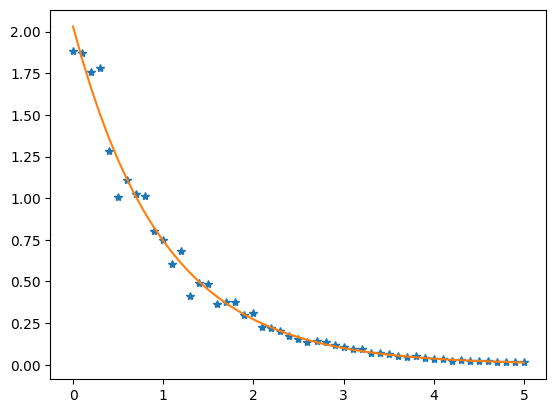

In [8]:
#Graficamos el ajuste obtenido

plot(x,y,"*")
plot(x,yest);

## Ejercicio

Considere el conjunto de datos de consumo de energía para 3 días que se da a continuación. Se desea ajustar una función de la forma:

$$f(x;\theta) = \theta_1 + \theta_2 \cos(2\pi\theta_4 x) + \theta_3 \sin(2\pi\theta_4 x).$$

1. Realice una estimación de la frecuencia adecuada usando los datos.
2. Ajuste por mímimos cuadrados lineales los parámetros $\theta_1,\theta_2,\theta_3$ asumiendo que le frecuencia es la correcta.
3. Mejore la estimación anterior usando mínimos cuadrados no lineales.


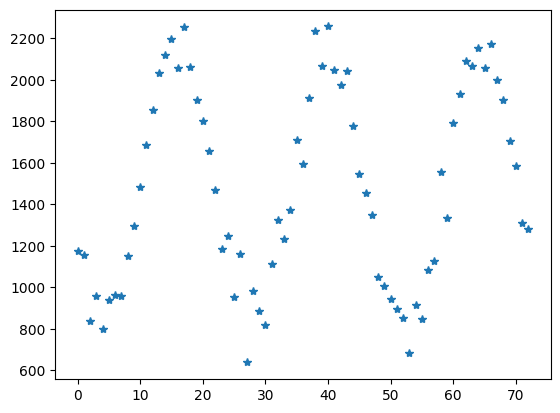

In [9]:
using PyPlot

x=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72];

y=[1173.15, 1158.19, 836.233, 956.135, 798.941, 940.874, 962.334, 960.576, 1151.08, 1295.21, 1482.07, 1686.09, 1855.18, 2031.19, 2118.81, 2193.92, 2054.85, 2254.63, 2063.09, 1900.01, 1801.31, 1658.79, 1470.5, 1184.17, 1248.86, 953.912, 1160.46, 638.465, 982.042, 888.076, 817.978, 1110.32, 1323.92, 1231.36, 1374.65, 1708.81, 1593.89, 1913.23, 2235.93, 2064.81, 2256.18, 2045.25, 1974.77, 2042.92, 1774.77, 1544.97, 1454.93, 1347.11, 1051.8, 1006.3, 942.056, 895.444, 851.086, 683.283, 914.18, 849.635, 1085.89, 1124.75, 1557.23, 1335.4, 1789.71, 1933.31, 2091.94, 2063.57, 2150.24, 2057.65, 2172.07, 1998.81, 1899.98, 1705.58, 1586.74, 1311.99, 1281.01];

plot(x,y,"*");